In [1]:
import os
import numpy as np
import mxnet as mx
from utils import check_dir
from memory import Memory
from utils import create_input, translate_state
from evaluation_mxnet import evaluate
from mxnet import gluon, nd, autograd
from environments.SimpleEnv import SimpleEnv
from model.simple_stack import SimpleStack
from PIL import Image

In [2]:
agent_view = 5
map_size = 20
rounds = 100
ctx = mx.gpu()
env = SimpleEnv(display=False, agent_view=agent_view, map_size=map_size)
model = SimpleStack()
model.load_parameters("./model_save/model_test.params.best", ctx)
save = "./data_save/"
print_action=False

In [3]:
avg_extrinsic_reward = []
avg_reward_rate = []

In [4]:
for epoch in range(rounds):
    env.reset_env()
    done = 0
    step = 0
    while not done:
        step += 1
        data = create_input([translate_state(env.map.state())])
        data = [nd.array(i, ctx=ctx) for i in data]
        pred = model(data)
        action = int(nd.argmax(pred, axis=1).asnumpy()[0])
        old, new, reward, done = env.step(action)
        if print_action:
            print(pred, reward, env.map.battery)
        if save is not None:
            img = Image.fromarray(env.map.grid.render(10,env.map.agent_pos,env.map.agent_dir), 'RGB')
            pred = [str(x)[0:5] for x in pred.asnumpy().tolist()[0]]
            filename = str(epoch) + "-" + str(step) + "-" + str(reward) + "-" + "_".join(pred) + ".jpg"
            img.save(save + "/" + filename)
    avg_reward_rate.append(env._rewards[-1] / sum([abs(i) for i in env._rewards]))
    avg_extrinsic_reward.append(env.map.extrinsic_reward())

In [5]:
np.mean(avg_extrinsic_reward), np.mean(avg_reward_rate)

(0.05411165876607052, 0.012547900814675635)

In [11]:
_view, _map, battery = data
_map = nd.transpose(_map, [1, 0, 2, 3])
_map, _memory = _map
_map = nd.expand_dims(_map, axis=1)
_memory = nd.expand_dims(_memory, axis=1)
_memory = model.memory(_memory)
_map = model.map(_map)
print(_map.shape, _memory.shape)

(1, 128, 7, 7) (1, 128, 7, 7)


In [12]:
import seaborn
import tqdm

100%|██████████| 99/99 [00:00<00:00, 8183.44it/s]


<AxesSubplot:>

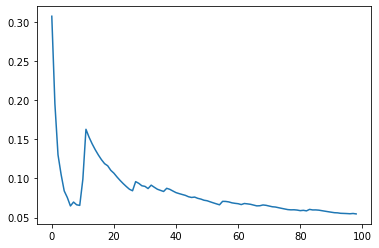

In [13]:
y = []
for i in tqdm.tqdm(range(1, len(env.detect_rate))):
    y.append(np.mean(env.detect_rate[:i]))
seaborn.lineplot(x=range(len(y)), y=y)

100%|██████████| 99/99 [00:00<00:00, 37385.08it/s]


<AxesSubplot:>

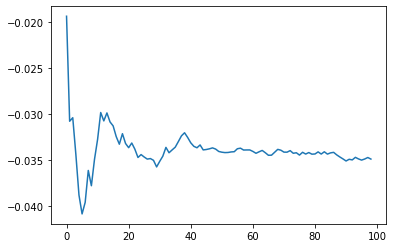

In [14]:
y = []
for i in tqdm.tqdm(range(1, len(env.rewards))):
    y.append(np.mean(env.rewards[:i]))
seaborn.lineplot(x=range(len(y)), y=y)

In [10]:
env._rewards

[-0.004,
 -0.005,
 -0.006,
 -0.007,
 -0.008,
 -0.009000000000000001,
 -0.01,
 -0.011,
 -0.012,
 -0.013,
 -0.014,
 -0.015,
 -0.016,
 -0.017,
 -0.018000000000000002,
 -0.019,
 -0.02,
 -0.021,
 -0.022,
 -0.023,
 -0.004,
 -0.005,
 -0.003,
 -0.004,
 -0.005,
 -0.006,
 -0.007,
 -0.008,
 -0.009000000000000001,
 -0.01,
 -0.003,
 -0.003,
 -0.004,
 -0.005,
 -0.003,
 -0.004,
 -0.005,
 -0.006,
 -0.007,
 -0.008,
 -0.009000000000000001,
 -0.01,
 -0.011,
 -0.012,
 -0.013000000000000001,
 -0.013999999999999999,
 -0.015,
 -0.016,
 -0.017,
 -0.018,
 -0.019,
 -0.02,
 -0.020999999999999998,
 -0.022,
 -0.023,
 -0.024,
 -0.024999999999999998,
 -0.026,
 -0.027,
 -0.028,
 -0.028999999999999998,
 -0.03,
 -0.031,
 -0.032,
 -0.033,
 -0.034,
 -0.035,
 -0.036000000000000004,
 -0.037000000000000005,
 -0.038000000000000006,
 -0.039,
 -0.04,
 -0.041,
 -0.042,
 -0.043000000000000003,
 -0.044000000000000004,
 -0.045000000000000005,
 -0.046,
 -0.047,
 -0.048,
 -0.049,
 -0.05,
 -0.051000000000000004,
 -0.05200000000000000